In [31]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from utils import config, utils

In [32]:
# Define the target and features
TARGET = "label"
FEATURES = ["text",]

In [33]:
df_tweets = pd.read_csv("../res/prepared/st-data-full.csv")

## Model training

### Pretrained

#### Ollama
Due to poor performance and long execution times, this model will no longer be evaluated. The results can be found in the notebook located at `src/archive/llm-ollama.ipynb`

In [34]:
ollama_model = "llama3.1:latest"

In [35]:
# ollama_pipeline = utils.OllamaPipeline(
#     df=df_tweets,
#     features=FEATURES,
#     target=TARGET,
#     ollama_model=ollama_model,
#     model_name=ollama_model,
# )

In [36]:
# ollama_pipeline.evaluate()

#### Huggingface

In [37]:
from transformers import pipeline
import tqdm

pipe = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


In [38]:
# display(df_tweets["title"], df_tweets["text"])

In [30]:
y_pred = []

for idx, row in tqdm.tqdm(df_tweets.iterrows(), desc="Predicting sentiment"):
    try:
        result = pipe(
            #{"text": row["title"], "text_pair": row["text"]},
            {"text": row["text"]},
            truncation=True  
        )
        y_pred.append(result)
    except Exception as e:
        print(idx, "|", e, "|", row["text"])
        y_pred.append({"label": "N/A"})
    
df_tweets["y_pred"] = y_pred

Predicting sentiment: 53it [00:02, 18.73it/s]

In [10]:
df_tweets.head()

,text,label
0,"if you were curious, price chose the lowest ch...",1
1,"true, not even 10k followers here yet.",1
2,dogecoin co-founder billy markus hits back at ...,1
3,"i’m curious, do any bulls have a price where ...",1
4,friday everybody buy 10 more on friday,2


In [11]:
# df_tweets["pred_sentiment"] = df_tweets["y_pred"].apply(lambda x: x["label"])
# df_tweets["pred_sentiment"] = df_tweets["pred_sentiment"].replace({"POS": "positive", "NEU": "neutral", "NEG": "negative"})
# df_tweets.head()

In [12]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# cm = confusion_matrix(df_tweets["sentiment"], df_tweets["pred_sentiment"], labels=config.SENTIMENTS, normalize="true")
# print(cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config.SENTIMENTS)
# disp.plot(cmap=plt.cm.Blues)

### Supervised

#### NLTK-Randomforest

In [13]:
nltk_rf_model = utils.CustomPipeline(
    df_tweets,
    FEATURES,
    TARGET, 
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer()),
                ('tfidf', TfidfVectorizer())
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", RandomForestClassifier(random_state=config.RANDOM_STATE, max_depth=35))
    ],
    model_name="nltk_rf"
)

In [14]:
# nltk_rf_model.fit(False)
# nltk_rf_model.fit(True)

In [15]:
# nltk_rf_model.evaluate(False, False)
# nltk_rf_model.evaluate(True, False)

In [16]:
# nltk_rf_model.dump("../res/models")

#### NLTK-NGrams-RDF

In [17]:
nltk_rf_ngram_1_3_model = utils.CustomPipeline(
    df_tweets,
    FEATURES,
    TARGET, 
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer()),
                ('tfidf', (TfidfVectorizer(ngram_range=(1, 3)))),
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", RandomForestClassifier(random_state=config.RANDOM_STATE, max_depth=35))
    ],
    model_name="nltk_rf_n_gram_1_3"
)

In [18]:
# nltk_rf_ngram_1_3_model.fit(True)
# nltk_rf_ngram_1_3_model.fit(False)

In [19]:
# nltk_rf_ngram_1_3_model.evaluate(False, False)
# nltk_rf_ngram_1_3_model.evaluate(True, False)

#### NLTK-NGrams-SVC

In [20]:
from sklearn.svm import SVC
nltk_svc_ngram_1_3_model = utils.CustomPipeline(
    df_tweets,
    FEATURES,
    TARGET, 
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer()),
                ('tfidf', (TfidfVectorizer(ngram_range=(1, 3)))),
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", SVC(random_state=config.RANDOM_STATE))
    ],
    model_name="nltk_svc_n_gram_1_3"
)

In [21]:
nltk_svc_ngram_1_3_model.fit(True)
nltk_svc_ngram_1_3_model.fit(False)

AttributeError: 'float' object has no attribute 'split'

Classification Report for nltk_svc_n_gram_1_3_balanced model_unbalanced test data:
              precision    recall  f1-score   support

    negative       0.96      0.89      0.92       745
     neutral       0.96      0.78      0.86      1298
    positive       0.83      0.98      0.90      1666

    accuracy                           0.89      3709
   macro avg       0.92      0.88      0.89      3709
weighted avg       0.90      0.89      0.89      3709

Confusion Matrix for nltk_svc_n_gram_1_3_balanced model_unbalanced test data:
[[0.88724832 0.02550336 0.08724832]
 [0.01232666 0.78274268 0.20493066]
 [0.00780312 0.01320528 0.9789916 ]]


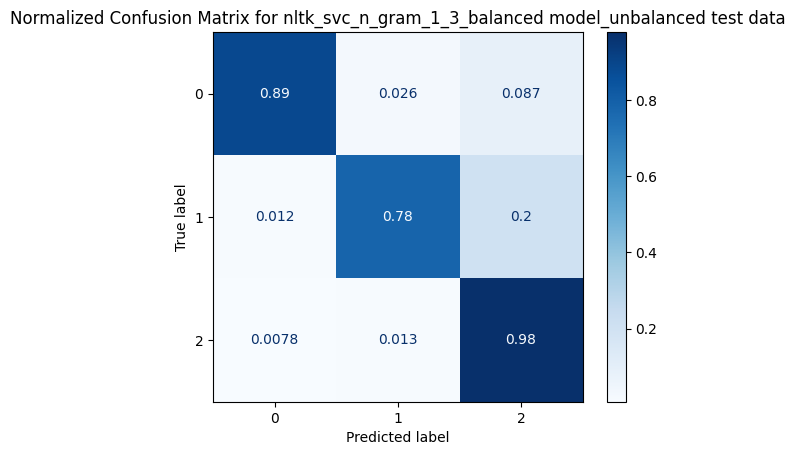

In [58]:
# nltk_rf_ngram_1_3_model.evaluate(False, False)
nltk_svc_ngram_1_3_model.evaluate(True, False)

In [59]:
nltk_svc_ngram_1_3_model.dump("../res/models")